## CNN Model with Tensorflow

I started with a kernal to understand the code for setting up a CNN model using tensorflow. 

https://www.kaggle.com/arjanso/simple-tensorflow-prediction-pipeline

In [ ]:
"""IMPORT"""
import numpy as np
import pandas as pd
import os
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import gc
import tensorflow as tf
from PIL import Image
from subprocess import check_output
import time

In [9]:
"""PREPARATION"""
train_path = 'data/stage1_train/'
train_ids = os.listdir(train_path)[1:]
subfolders = ["images","masks"]
train_list = []


"""We want 50 256x256x4 images"""
shape = 256, 256, 4
m = 50

In [11]:
len(train_ids)

670

### Preprocess images and masks

In [12]:
def get_XY(shape, m, train_path, train_ids):
    """
    Description: 
        This function loops over the training ID's and masks to select m images and labels that match the 
        desired shape and return it. 
    Input: 
        - shape: dimensions of the picture (height x width x channels), a selection criterion
        - m: number of samples, a selection criterion
        - train_path: path of the train folder
        - train_ids: list of training Ids.
    Output: 
        - X: A stack of images. dimension is  (m x shape) where shape is (height x width x channels)
        - Y: A stack of labels to predict. sum of all masks for that object
    """
    i=0  # keep track of number of images retrieved
    init_Y = False  # define whether Y is initialized
    init_X = False  # define whether X is initialized
    
    #  Loop over the training id's.
    for train_id in train_ids:
        
        # Load an image
        x_path = train_path + train_id + "/images/" + train_id +  ".png"
        x = Image.open(x_path)
        x = np.array(x)
        
        # Check if the size matches the expected size, else ignore 
        if shape != x.shape:
            continue 
        
        # Add an axis to stack the samples along. 
        x = np.expand_dims(x,0)
        
        # Stack the training examples
        if not init_X:
            X = x
            init_X = True
        else:
            X = np.vstack([X,x])
    
        # Load a mask
        y_path = train_path + train_id + "/masks/" 
        maskpaths = os.listdir(y_path)

        # A single image id has multiple masks -> sum over the masks to create 1 label per image id.
        init_y = False
        for maskpath in maskpaths:
            temppath = y_path + maskpath
            if not init_y:
                y = Image.open(temppath)
                y = np.array(y)
                init_y = True
            else:
                temp = Image.open(temppath)
                temp = np.array(temp)
                y = y + temp       

        # Add an axis to stack the samples along.       
        y = np.expand_dims(y,0)
        print(y.shape)
        if not init_Y:
            Y = y
            init_Y = True
        else:
            Y = np.vstack([Y,y])
        i+=1
        print(i)
        if i >= m:
            print("sampling limit reached.")
            Y = np.expand_dims(Y,3)
            Y = Y/255
            X = X/255
            return X,Y

In [13]:
X,Y = get_XY(shape, m, train_path, train_ids)

(1, 256, 256)
1
(1, 256, 256)
2
(1, 256, 256)
3
(1, 256, 256)
4
(1, 256, 256)
5
(1, 256, 256)
6
(1, 256, 256)
7
(1, 256, 256)
8
(1, 256, 256)
9
(1, 256, 256)
10
(1, 256, 256)
11
(1, 256, 256)
12
(1, 256, 256)
13
(1, 256, 256)
14
(1, 256, 256)
15
(1, 256, 256)
16
(1, 256, 256)
17
(1, 256, 256)
18
(1, 256, 256)
19
(1, 256, 256)
20
(1, 256, 256)
21
(1, 256, 256)
22
(1, 256, 256)
23
(1, 256, 256)
24
(1, 256, 256)
25
(1, 256, 256)
26
(1, 256, 256)
27
(1, 256, 256)
28
(1, 256, 256)
29
(1, 256, 256)
30
(1, 256, 256)
31
(1, 256, 256)
32
(1, 256, 256)
33
(1, 256, 256)
34
(1, 256, 256)
35
(1, 256, 256)
36
(1, 256, 256)
37
(1, 256, 256)
38
(1, 256, 256)
39
(1, 256, 256)
40
(1, 256, 256)
41
(1, 256, 256)
42
(1, 256, 256)
43
(1, 256, 256)
44
(1, 256, 256)
45
(1, 256, 256)
46
(1, 256, 256)
47
(1, 256, 256)
48
(1, 256, 256)
49
(1, 256, 256)
50
sampling limit reached.


In [14]:
# check the shapes
print("X.shape = ",X.shape)
print("Y.shape = ",Y.shape)

X.shape =  (50, 256, 256, 4)
Y.shape =  (50, 256, 256, 1)


Text(0.5,1,'mask')

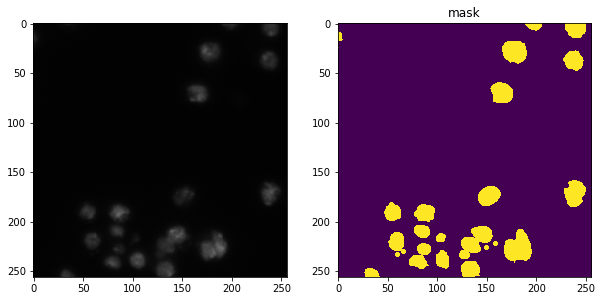

In [30]:
# check a sample 
fig, axs = plt.subplots(1, 2, figsize=(10,10))
axs[0].imshow(X[0])
plt.title("Image")
axs[1].imshow(np.squeeze(Y[0]))
plt.title("mask")


### CNN Tensorflow Model

In [31]:
# Placeholders can be used to define the computations graph
def get_placeholders(size):
    Xtf = tf.placeholder(name="Xtf",shape=[None,size[0],size[1],4],dtype="float")
    Ytf = tf.placeholder(name="Ytf",shape=[None,size[0],size[1],1],dtype="float")
    return Xtf, Ytf

In [32]:
def go_forward(Xtf):
    
    # PARAMETERS
    W1 = tf.get_variable("W1",shape=[3,3,4,32],initializer=tf.contrib.layers.xavier_initializer(seed=0),dtype="float")
    W2 = tf.get_variable("W2",shape=[3,3,32,64],initializer=tf.contrib.layers.xavier_initializer(seed=0),dtype="float")
    W3 = tf.get_variable("W3",shape=[3,3,64,128],initializer=tf.contrib.layers.xavier_initializer(seed=0),dtype="float")
    W4 = tf.get_variable("W4",shape=[3,3,128,1],initializer=tf.contrib.layers.xavier_initializer(seed=0),dtype="float")

    # LAYER 1
    Z1 = tf.nn.conv2d(Xtf,W1,strides=[1,1,1,1],padding="SAME")
    A1 = tf.nn.relu(Z1)
    
    # LAYER 2
    Z2 = tf.nn.conv2d(A1,W2,strides=[1,1,1,1],padding="SAME")
    A2 = tf.nn.relu(Z2)
    
    # LAYER 3
    Z3 = tf.nn.conv2d(A2,W3,strides=[1,1,1,1],padding="SAME")
    A3 = tf.nn.relu(Z3)
    
    # LAYER 4
    Z4 = tf.nn.conv2d(A3,W4,strides=[1,1,1,1],padding="SAME")
    A4 = tf.nn.sigmoid(Z4)
    
    return A4

### Intersection of Union Metric (IoU)

In [33]:
def compute_cost(A4, Y):
    print("A4 ",A4.shape)
    Y_negatives = tf.subtract(1.,Y)
    print("Y_neg ",Y_negatives)
    tp = tf.reduce_sum(tf.reduce_sum(tf.multiply(A4,Y),1),1)  # True positives (i.e. the intersection)
    print("true_pos ",tp)
    fp = tf.reduce_sum(tf.reduce_sum(tf.multiply(A4,Y_negatives),1),1)  # False positives
    fn = tf.reduce_sum(tf.reduce_sum(tf.multiply(tf.subtract(Y,A4),Y),1),1)  # False negatives
    un_temp = tf.add(tp,fp)  # sum of true and false positvives
    un = tf.add(un_temp,fn)  # The union
    iou = tf.divide(tp,un)  # the intersection over union
    cost = tf.subtract(1.,tf.reduce_mean(iou))  # the cost
    return (cost, tp, fp, fn)

### Run the model

In [34]:
tf.reset_default_graph()
best_score = 1.
best_iter = 0
start_time = time.time()
max_duration = 900
max_iterations = 80
X_train = X[:-10]
X_valid = X[-10:]
Y_train = Y[:-10]
Y_valid = Y[-10:]
train_costs = [1] * max_iterations
valid_costs = [1] * max_iterations
with tf.Session() as sess:    
    Xtf, Ytf = get_placeholders(shape)
    A4 = go_forward(Xtf)
    cost, tp, fp, fn = compute_cost(A4,Ytf)
    optimizer = tf.train.AdamOptimizer(learning_rate=0.002).minimize(cost)
    init = tf.global_variables_initializer()
    sess.run(init)
    for i in range(max_iterations):
        pred, train_costs[i],tpo, fpo, fno = sess.run([optimizer,cost, tp, fp, fn],feed_dict={Xtf:X_train,Ytf:Y_train})
        valid_costs[i] = sess.run(cost,feed_dict={Xtf:X_valid,Ytf:Y_valid})

        print("\n************************")
        print("iter:",i)
        print("training cost:",train_costs[i])
        print("valid cost:",valid_costs[i])
        print("************************\n")
        
        if train_costs[i] > best_score and best_iter <= i-10:
            print("Converged")
            break
        elif time.time() >= start_time + max_duration:
            print("timed out")
            break
        else:
            best_score = train_costs[i]
            best_iter = i
    prediction, iou_pred = sess.run([A4,cost],{Xtf:X_valid,Ytf:Y_valid})
    print("validation cost: ",iou_pred)
#%%  CHECK OUTPUT

A4  (?, 256, 256, 1)
Y_neg  Tensor("Sub:0", shape=(?, 256, 256, 1), dtype=float32)
true_pos  Tensor("Sum_1:0", shape=(?, 1), dtype=float32)

************************
iter: 0
training cost: 0.940071
valid cost: 0.911024
************************


************************
iter: 1
training cost: 0.931973
valid cost: 0.907909
************************


************************
iter: 2
training cost: 0.93024
valid cost: 0.902692
************************


************************
iter: 3
training cost: 0.925362
valid cost: 0.89202
************************


************************
iter: 4
training cost: 0.913874
valid cost: 0.881397
************************


************************
iter: 5
training cost: 0.900952
valid cost: 0.866715
************************


************************
iter: 6
training cost: 0.885355
valid cost: 0.841606
************************


************************
iter: 7
training cost: 0.860639
valid cost: 0.804913
************************


*********************

### Learning Curve

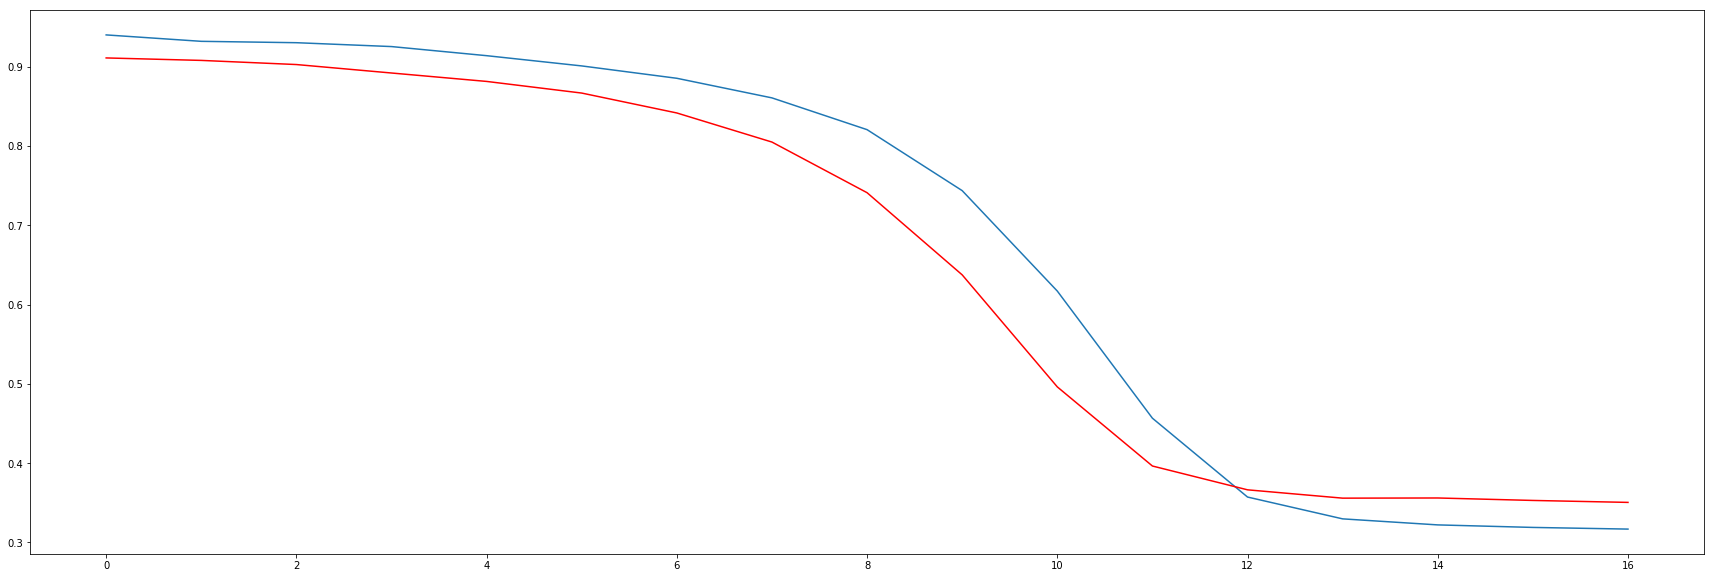

In [35]:
plt.figure(figsize=(30,10))
plt.plot(range(i),train_costs[:i],label="neg. training IOU")
plt.plot(range(i),valid_costs[:i],label="neg. validation IOU",c='r')

### Visualization

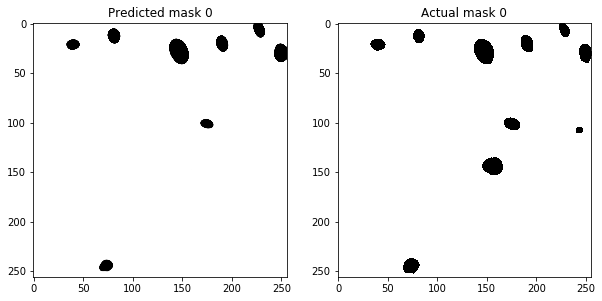

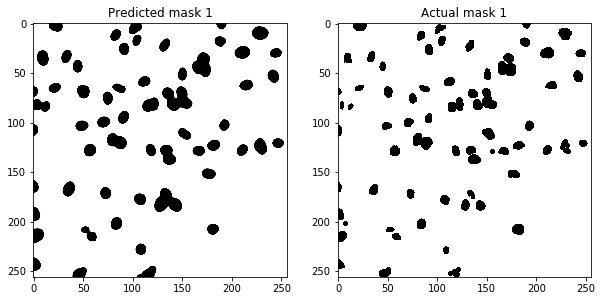

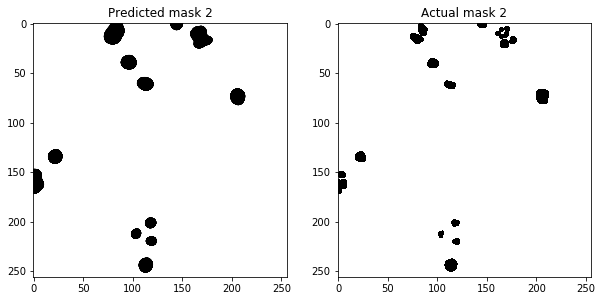

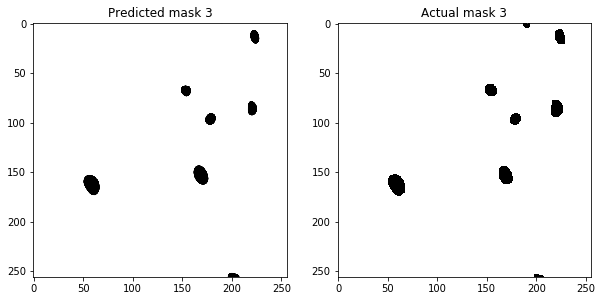

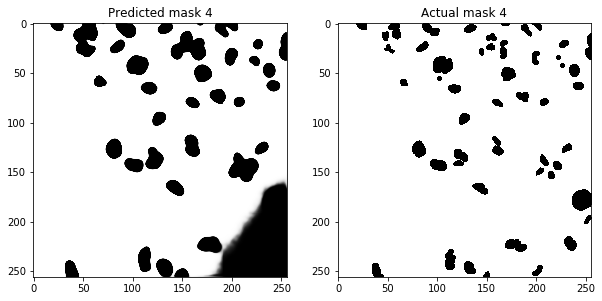

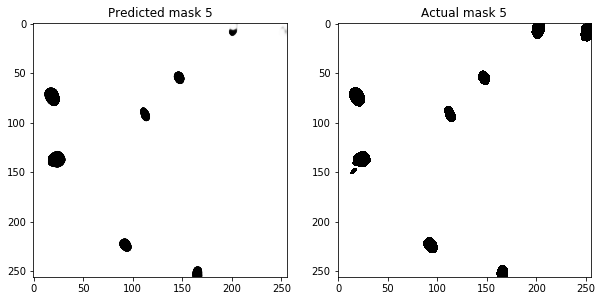

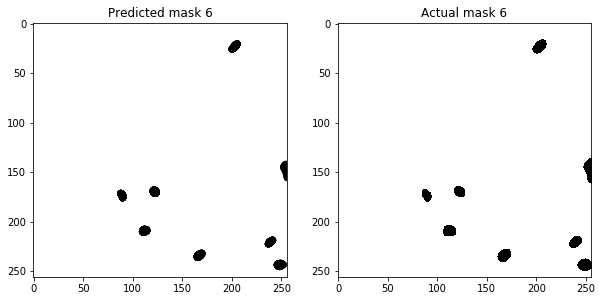

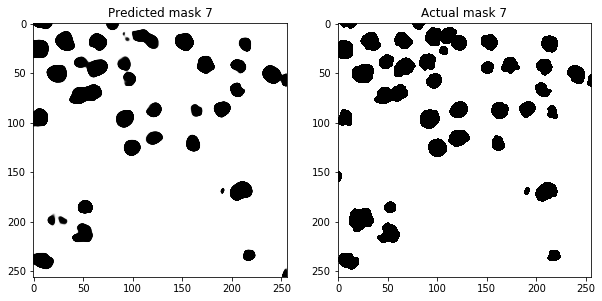

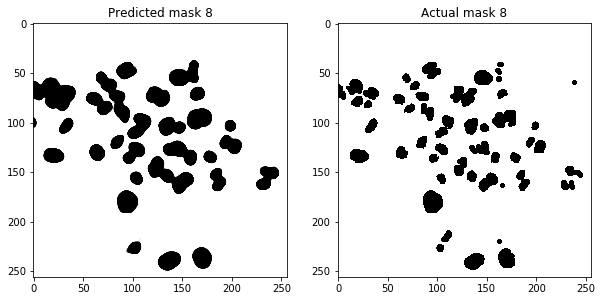

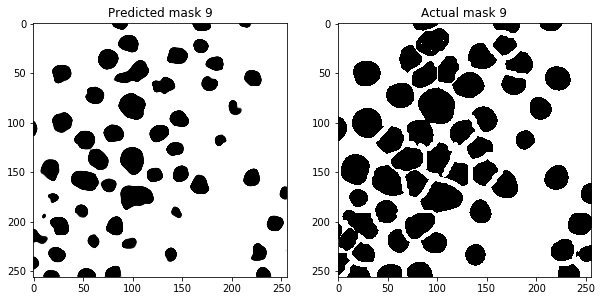

In [36]:
def show(out,Y,i=0):
    fig = plt.figure(figsize=(10,15))
        

    ax_1 = fig.add_subplot(1,2,1)
    ax_1.set_title("Predicted mask " + str(i),fontsize=12)
    ax_1.imshow(np.squeeze(out[i]),cmap="Greys")
    
    ax_2 = fig.add_subplot(1,2,2)
    ax_2.set_title("Actual mask " + str(i),fontsize=12)
    ax_2.imshow(np.squeeze(Y[i]),cmap="Greys")

    plt.show()

for j in range(10):
    show(prediction,Y_valid,i=j)

### Resources

https://www.quora.com/How-does-the-region-proposal-network-RPN-in-Faster-R-CNN-work

https://www.kaggle.com/arjanso/simple-tensorflow-prediction-pipeline

https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python